# Time Series Models: Assignment 1

#### Import data & Packages

In [60]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from scipy.stats import skew, kurtosis
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from scipy.optimize import minimize
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
df=pd.read_excel("./Nile.xlsx")

#### Inspecting Data

In [3]:
df.dtypes

Unnamed: 0    int64
Nile          int64
dtype: object

## Figure 2.1

In [4]:
df1 = df.copy() #creating new df to store data for first figure
df1.rename(columns={'Unnamed: 0': 'Year'}, inplace=True)
df1['at'] = 0
df1['Pt'] = 0
df1['vt'] = 0
df1['Ft'] = 0
df1['Kt'] = 0

#setting initialization
n = len(df1.index)
sigE = 15099
sigN = 1469.1

df1.loc[0,'Pt']= 10**7

#starting KF for-loop
for i in range(n):
    df1.loc[i,'vt'] = df1.loc[i, 'Nile'] - df1.loc[i, 'at']                  #prediction error
    df1.loc[i,'Ft'] = df1.loc[i, 'Pt'] + sigE                                #prediction error variance
    df1.loc[i,'Kt'] = df1.loc[i, 'Pt'] / df1.loc[i, 'Ft']                    #Kalman gain
    df1.loc[i+1,'at'] = df1.loc[i, 'at'] + df1.loc[i, 'Kt']*df1.loc[i, 'vt'] #prediction of level/signal
    df1.loc[i+1,'Pt'] = df1.loc[i, 'Kt']*sigE + sigN                         #prediction variance

In [5]:
df1 = df1.iloc[0:n,:] #removing last row since its not relevant
df1.tail()

,Year,Nile,at,Pt,vt,Ft,Kt
95,1966.0,746.0,963.752506,5501.257942,-217.752506,20600.257942,0.267048
96,1967.0,919.0,905.602132,5501.257942,13.397868,20600.257942,0.267048
97,1968.0,718.0,909.180006,5501.257942,-191.180006,20600.257942,0.267048
98,1969.0,714.0,858.125766,5501.257942,-144.125766,20600.257942,0.267048
99,1970.0,740.0,819.637266,5501.257942,-79.637266,20600.257942,0.267048


In [6]:
#adding confidence intervals
df1['CI_high'] = df1.loc[:,'at'] + scipy.stats.norm.ppf(0.95)*np.sqrt(df1.loc[:,'Pt'])
df1['CI_low'] = df1.loc[:,'at'] - scipy.stats.norm.ppf(0.95)*np.sqrt(df1.loc[:,'Pt'])
df1.head()

,Year,Nile,at,Pt,vt,Ft,Kt,CI_high,CI_low
0,1871.0,1120.0,0.000000,1.000000e+07,1120.000000,1.001510e+07,0.998492,5201.483879,-5201.483879
1,1872.0,1160.0,1118.311462,1.654534e+04,41.688538,3.164434e+04,0.522853,1329.886806,906.736117
2,1873.0,963.0,1140.108439,9.363658e+03,-177.108439,2.446266e+04,0.382774,1299.274335,980.942544
3,1874.0,1210.0,1072.316018,7.248597e+03,137.683982,2.234760e+04,0.324357,1212.356710,932.275327
4,1875.0,1160.0,1116.974768,6.366565e+03,43.025232,2.146556e+04,0.296594,1248.218883,985.730653


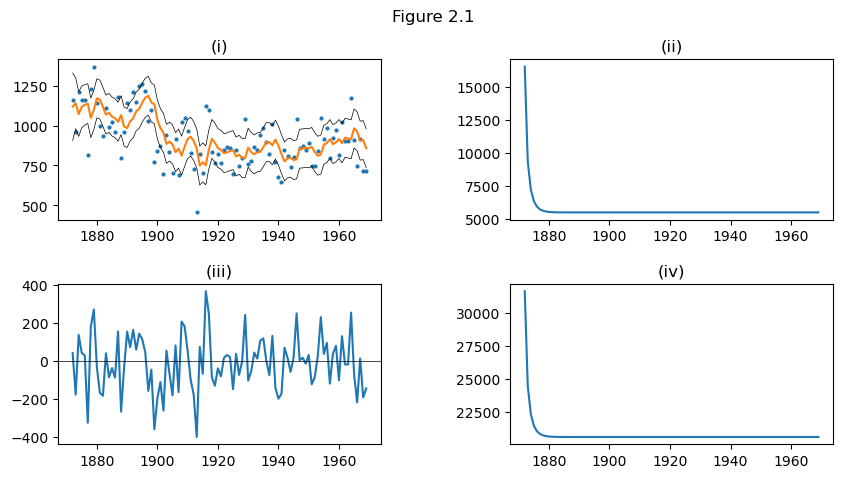

In [64]:
x = df1.loc[1:n,'Year'].astype(int)
fig_1 = plt.figure(figsize=(10,5))
plt.subplot(2, 2, 1)
plt.plot(x, df1.loc[1:n,'Nile'], 'o', markersize=2)
plt.plot(x, df1.loc[1:n,'at'])
plt.plot(x, df1.loc[1:n,'CI_high'], linewidth=0.5, color='black')
plt.plot(x, df1.loc[1:n,'CI_low'], linewidth=0.5, color='black')
plt.title("(i)")

plt.subplot(2, 2, 2)
plt.plot(x, df1.loc[1:n,'Pt'])
plt.title("(ii)")

plt.subplot(2, 2, 3)
plt.plot(x, df1.loc[1:n,'vt'])
plt.axhline(y=0, linewidth=0.5, color='black')
plt.title("(iii)")

plt.subplot(2, 2, 4)
plt.plot(x, df1.loc[1:n,'Ft'])
plt.title("(iv)")

# add a title for the entire figure
plt.suptitle('Figure 2.1', fontsize= 12)

plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

### Figure 2.2

In [8]:
df2 = df1.copy()
df2 = df2.drop(['CI_high', 'CI_low'], axis=1)
df2['rt'] = 0
df2['Nt'] = 0
df2['At'] = 0
df2['Vt'] = 0

for i in range(n-1, -1, -1):
    #print(i)
    df2.loc[i-1,'rt'] = (df2.loc[i, 'vt'] / df2.loc[i, 'Ft']) + (1-df2.loc[i, 'Kt'])*df2.loc[i, 'rt']
    df2.loc[i-1,'Nt'] = (1 / df2.loc[i, 'Ft']) + ((1-df2.loc[i, 'Kt'])**2)*df2.loc[i, 'Nt']
    df2.loc[i,'At'] = df2.loc[i,'at'] + df2.loc[i,'Pt']*df2.loc[i-1,'rt']
    df2.loc[i,'Vt'] = df2.loc[i,'Pt'] - (df2.loc[i,'Pt']**2)*df2.loc[i-1,'Nt']

df2 = df2.iloc[0:n,:] #removing last row since its not relevant

#adding confidence intervals
df2['CI_high'] = df2.loc[:,'At'] + scipy.stats.norm.ppf(0.95)*np.sqrt(df2.loc[:,'Vt'])
df2['CI_low'] = df2.loc[:,'At'] - scipy.stats.norm.ppf(0.95)*np.sqrt(df2.loc[:,'Vt'])

df2.tail()

,Year,Nile,at,Pt,vt,Ft,Kt,rt,Nt,At,Vt,CI_high,CI_low
95,1966.0,746.0,963.752506,5501.257942,-217.752506,20600.257942,0.267048,-0.011433,0.000096,859.504467,2468.803438,941.232400,777.776534
96,1967.0,919.0,905.602132,5501.257942,13.397868,20600.257942,0.267048,-0.016485,0.000089,842.708974,2591.167976,926.437807,758.980140
97,1968.0,718.0,909.180006,5501.257942,-191.180006,20600.257942,0.267048,-0.009830,0.000075,818.490529,2818.942170,905.821913,731.159146
98,1969.0,714.0,858.125766,5501.257942,-144.125766,20600.257942,0.267048,-0.003866,0.000049,804.049596,3242.930073,897.718631,710.380560
99,1970.0,740.0,819.637266,5501.257942,-79.637266,20600.257942,0.267048,0.000000,0.000000,798.370293,4032.157942,902.817306,693.923280


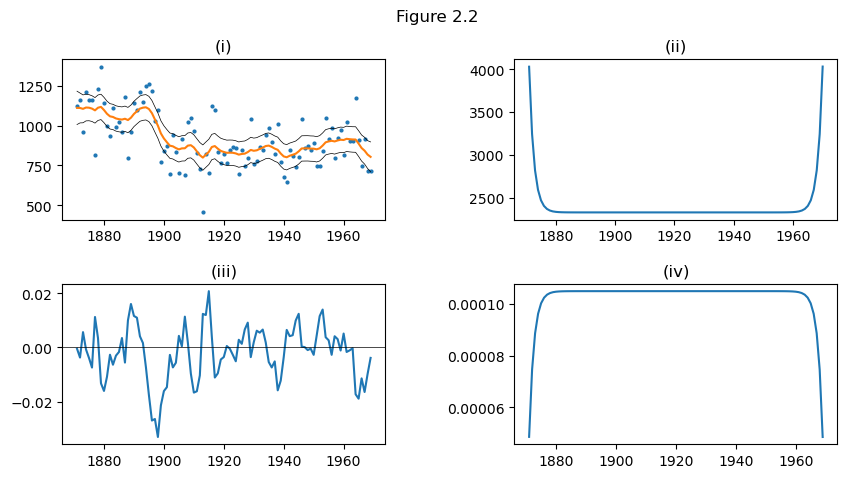

In [80]:
n=98
x = df2.loc[0:n,'Year'].astype(int)
fig_2 = plt.figure(figsize=(10,5))
plt.subplot(2, 2, 1)
plt.plot(x, df2.loc[0:n,'Nile'], 'o', markersize=2)
plt.plot(x, df2.loc[0:n,'At'])
plt.plot(x, df2.loc[0:n,'CI_high'], linewidth=0.5, color='black')
plt.plot(x, df2.loc[0:n,'CI_low'], linewidth=0.5, color='black')
plt.title("(i)")

x = df2.loc[0:n+1,'Year'].astype(int)
plt.subplot(2, 2, 2)
plt.plot(x, df2.loc[0:n+1,'Vt'])
plt.title("(ii)")

x = df2.loc[0:n,'Year'].astype(int)
plt.subplot(2, 2, 3)
plt.plot(x, df2.loc[0:n,'rt'])
plt.axhline(y=0, linewidth=0.5, color='black')
plt.title("(iii)")

plt.subplot(2, 2, 4)
plt.plot(x, df2.loc[0:n,'Nt'])
plt.title("(iv)")

# add a title for the entire figure
fig_2.suptitle('Figure 2.2', fontsize= 12)

plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

### Figure 2.3

In [10]:
df2_copy = df2.copy()

In [11]:
##Expecation ε t
df2_copy['Exp_e'] = sigE*((df2.loc[:,'vt']/df2.loc[:,'Ft']) - (df2.loc[:,'Kt']*df2.loc[:,'rt']))

##Var of Epsilon t
df2_copy['Var_e'] = np.sqrt(sigE-sigE*(1/df2_copy.loc[:,'Ft'] + df2_copy.loc[:,'Kt']*df2_copy.loc[:,'Nt']*df2_copy.loc[:, 'Kt'])*sigE)

###Expectation ηt 
sigN = 1469.1
df2_copy['Exp_h'] = sigN*1*df2_copy.loc[:,'rt']

##Var of ηt
df2_copy['Var_h'] = np.sqrt(sigN - sigN*2*1*df2_copy.loc[:, 'Nt']*1*sigN)

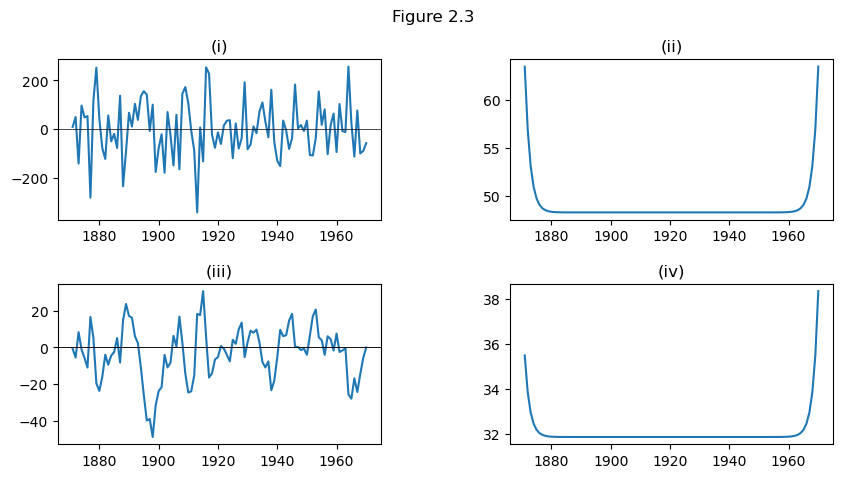

In [69]:
###Ploting of 2.3
x = df2_copy.loc[:,'Year'].astype(int)
fig_3 = plt.figure(figsize=(10,5))
plt.subplot(2, 2, 1)
plt.plot(x, df2_copy.loc[:,'Exp_e'], markersize=2)
plt.title("(i)")
plt.axhline(y=0, color='black', linewidth=0.5)

plt.subplot(2, 2, 2)
plt.plot(x, df2_copy.loc[:,'Var_e'])
plt.title("(ii)")

plt.subplot(2, 2, 3)
plt.plot(x, df2_copy.loc[:,'Exp_h'])
plt.axhline(y=0, linewidth=0.5, color='black')
plt.title("(iii)")
plt.axhline(y=0, color='black', linewidth=0.5)


plt.subplot(2, 2, 4)
plt.plot(x, df2_copy.loc[:,'Var_h'])
plt.title("(iv)")

# add a title for the entire figure
plt.suptitle('Figure 2.3', fontsize= 12)


plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

### Figure 2.4

In [13]:
# drawing random errors
# setting seed
np.random.seed(888)

# setting sigma_e and sigma_eta
sigE = 15099
sigN = 1469.1

# drawing random errors
df2_4 = df2_copy.drop(['CI_high', 'CI_low'], axis =1).copy()
E_plus = np.random.normal(loc=0.0, scale=np.sqrt(sigE), size=len(df2_4))
Eta_plus = np.random.normal(loc=0.0, scale=np.sqrt(sigN), size=len(df2_4))

In [14]:
# checking size of array
print("E_plus size:", E_plus.size)
print("Eta_plus size:", Eta_plus.size)

E_plus size: 100
Eta_plus size: 100


In [15]:
df_simulated = pd.DataFrame(columns=['alpha_plus'])
df_simulated['alpha_hat'] =  df2_4['At']
df_simulated['Eta_plus'] = Eta_plus
df_simulated['E_plus'] = E_plus
df_simulated['E_hat'] = df2_4['Exp_e']
df_simulated['Eta_hat'] = df2_4['Exp_h']
df_simulated['Nile'] = df2_4['Nile']
df_simulated['Year'] = df2_4['Year'].astype(int)

In [16]:
df_simulated.head()

,alpha_plus,alpha_hat,Eta_plus,E_plus,E_hat,Eta_hat,Nile,Year
0,NaN,1111.220258,-2.954992,-21.651209,8.779742,-0.691001,1120.0,1871
1,NaN,1110.529257,4.494714,23.208747,49.470743,-5.504397,1160.0,1872
2,NaN,1105.024860,10.358475,101.589030,-142.024860,8.314315,963.0,1873
3,NaN,1113.339175,-22.371131,-3.987061,96.660825,-1.090574,1210.0,1874
4,NaN,1112.248601,-61.060504,-80.177816,47.751399,-5.736682,1160.0,1875


In [17]:
df_simulated['alpha_plus'] = df2_4['Nile'][0]
for i in range(len(df_simulated)):
    df_simulated.loc[i + 1, 'alpha_plus'] = df_simulated.loc[i, 'alpha_plus'] + df_simulated.loc[i, 'Eta_plus']
df_simulated['Y_plus'] = df_simulated['alpha_plus'] + df_simulated['E_plus']
df_simulated = df_simulated.loc[:99,]
df_simulated.head(10)

,alpha_plus,alpha_hat,Eta_plus,E_plus,E_hat,Eta_hat,Nile,Year,Y_plus
0,1120.000000,1111.220258,-2.954992,-21.651209,8.779742,-0.691001,1120.0,1871.0,1098.348791
1,1117.045008,1110.529257,4.494714,23.208747,49.470743,-5.504397,1160.0,1872.0,1140.253755
2,1121.539722,1105.024860,10.358475,101.589030,-142.024860,8.314315,963.0,1873.0,1223.128753
3,1131.898198,1113.339175,-22.371131,-3.987061,96.660825,-1.090574,1210.0,1874.0,1127.911137
4,1109.527067,1112.248601,-61.060504,-80.177816,47.751399,-5.736682,1160.0,1875.0,1029.349251
5,1048.466563,1106.511919,-36.987140,-12.943891,53.488081,-10.940957,1160.0,1876.0,1035.522671
6,1011.479422,1095.570962,29.810853,26.759891,-282.570962,16.552586,813.0,1877.0,1038.239313
7,1041.290275,1112.123548,19.729472,72.163970,117.876452,5.083463,1230.0,1878.0,1113.454245
8,1061.019747,1117.207011,54.866093,12.317031,252.792989,-19.512748,1370.0,1879.0,1073.336777
9,1115.885840,1097.694263,14.109289,-135.159235,42.305737,-23.629004,1140.0,1880.0,980.726605


In [18]:
# Filter
df_simulated['at'] = 0
df_simulated['Pt'] = 0
df_simulated['vt'] = 0
df_simulated['Ft'] = 0
df_simulated['Kt'] = 0
df_simulated.loc[0,'Pt']= 10**7

#setting initialization
n = len(df_simulated)

for i in range(n):
    df_simulated.loc[i,'vt'] = df_simulated.loc[i, 'Y_plus'] - df_simulated.loc[i, 'at']                  #prediction error
    df_simulated.loc[i,'Ft'] = df_simulated.loc[i, 'Pt'] + sigE                                #prediction error variance
    df_simulated.loc[i,'Kt'] = df_simulated.loc[i, 'Pt'] / df_simulated.loc[i, 'Ft']                    #Kalman gain
    df_simulated.loc[i+1,'at'] = df_simulated.loc[i, 'at'] + df_simulated.loc[i, 'Kt']*df_simulated.loc[i, 'vt'] #prediction of level/signal
    df_simulated.loc[i+1,'Pt'] = df_simulated.loc[i, 'Kt']*sigE + sigN                         #prediction variance

df_simulated = df_simulated.iloc[0:n,:] #removing last row since its not relevant

# Smoother
df_simulated['rt'] = 0
df_simulated['Nt'] = 0
# df_simulated['At'] = 0
df_simulated['Vt'] = 0

for i in range(n-1, -1, -1):
    #print(i)
    df_simulated.loc[i-1,'rt'] = (df_simulated.loc[i, 'vt'] / df_simulated.loc[i, 'Ft']) + (1-df_simulated.loc[i, 'Kt'])*df_simulated.loc[i, 'rt']
    df_simulated.loc[i-1,'Nt'] = (1 / df_simulated.loc[i, 'Ft']) + ((1-df_simulated.loc[i, 'Kt'])**2)*df_simulated.loc[i, 'Nt']
    df_simulated.loc[i,'A_hat_plus'] = df_simulated.loc[i,'at'] + df_simulated.loc[i,'Pt']*df_simulated.loc[i-1,'rt']
    df_simulated.loc[i,'Vt'] = df_simulated.loc[i,'Pt'] - (df_simulated.loc[i,'Pt']**2)*df_simulated.loc[i-1,'Nt']
df_simulated = df_simulated.iloc[0:n,:] #removing last row since its not relevant

In [19]:
df_simulated.head()

,alpha_plus,alpha_hat,Eta_plus,E_plus,E_hat,Eta_hat,Nile,Year,Y_plus,at,Pt,vt,Ft,Kt,rt,Nt,Vt,A_hat_plus
0,1120.000000,1111.220258,-2.954992,-21.651209,8.779742,-0.691001,1120.0,1871.0,1098.348791,0.000000,1.000000e+07,1098.348791,1.001510e+07,0.998492,0.001292,0.000049,4030.532767,1116.177726
1,1117.045008,1110.529257,4.494714,23.208747,49.470743,-5.504397,1160.0,1872.0,1140.253755,1096.692895,1.654534e+04,43.560861,3.164434e+04,0.522853,-0.000176,0.000075,3242.056999,1118.076420
2,1121.539722,1105.024860,10.358475,101.589030,-142.024860,8.314315,963.0,1873.0,1223.128753,1119.468822,9.363658e+03,103.659931,2.446266e+04,0.382774,-0.007151,0.000089,2818.473138,1117.817308
3,1131.898198,1113.339175,-22.371131,-3.987061,96.660825,-1.090574,1210.0,1874.0,1127.911137,1159.147098,7.248597e+03,-31.235961,2.234760e+04,0.324357,-0.008515,0.000096,2590.916003,1107.311620
4,1109.527067,1112.248601,-61.060504,-80.177816,47.751399,-5.736682,1160.0,1875.0,1029.349251,1149.015499,6.366565e+03,-119.666248,2.146556e+04,0.296594,-0.004181,0.000100,2468.668074,1094.801644


In [20]:
df_simulated['u_t_plus'] = (df_simulated['vt'] / df_simulated['Ft']) - (df_simulated['Kt'] * df_simulated['rt'])
df_simulated['E_hat_plus'] = sigE * df_simulated['u_t_plus']
df_simulated['E_tilda'] = df_simulated['E_plus'] - df_simulated['E_hat_plus'] + df_simulated['E_hat']
df_simulated['A_tilda'] = df_simulated['alpha_hat'] + df_simulated['alpha_plus'] - df_simulated['A_hat_plus']
Eta_tilda = [df_simulated['A_tilda'][i+1] - df_simulated['A_tilda'][i] for i in range(len(df_simulated)-1)]

In [21]:
df_simulated

,alpha_plus,alpha_hat,Eta_plus,E_plus,E_hat,Eta_hat,Nile,Year,Y_plus,at,...,Ft,Kt,rt,Nt,Vt,A_hat_plus,u_t_plus,E_hat_plus,E_tilda,A_tilda
0,1120.000000,1111.220258,-2.954992,-21.651209,8.779742,-0.691001,1120.0,1871.0,1098.348791,0.000000,...,1.001510e+07,0.998492,0.001292,0.000049,4030.532767,1116.177726,-0.001181,-17.828935,4.957468,1115.042532
1,1117.045008,1110.529257,4.494714,23.208747,49.470743,-5.504397,1160.0,1872.0,1140.253755,1096.692895,...,3.164434e+04,0.522853,-0.000176,0.000075,3242.056999,1118.076420,0.001469,22.177335,50.502155,1109.497845
2,1121.539722,1105.024860,10.358475,101.589030,-142.024860,8.314315,963.0,1873.0,1223.128753,1119.468822,...,2.446266e+04,0.382774,-0.007151,0.000089,2818.473138,1117.817308,0.006975,105.311445,-145.747275,1108.747275
3,1131.898198,1113.339175,-22.371131,-3.987061,96.660825,-1.090574,1210.0,1874.0,1127.911137,1159.147098,...,2.234760e+04,0.324357,-0.008515,0.000096,2590.916003,1107.311620,0.001364,20.599517,72.074248,1137.925752
4,1109.527067,1112.248601,-61.060504,-80.177816,47.751399,-5.736682,1160.0,1875.0,1029.349251,1149.015499,...,2.146556e+04,0.296594,-0.004181,0.000100,2468.668074,1094.801644,-0.004335,-65.452393,33.025977,1126.974023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,920.812195,859.504467,-10.557891,118.241279,-113.504467,-16.795493,746.0,1966.0,1039.053474,984.666376,...,2.060026e+04,0.267048,-0.001218,0.000096,2468.803438,994.280676,0.002965,44.772798,-40.035985,786.035985
96,910.254303,842.708974,0.218597,105.818890,76.291026,-24.218445,919.0,1967.0,1016.073194,999.190342,...,2.060026e+04,0.267048,-0.002779,0.000089,2591.167976,992.491859,0.001562,23.581334,158.528582,760.471418
97,910.472901,818.490529,3.603694,241.140971,-100.490529,-14.440934,718.0,1968.0,1151.613871,1003.698874,...,2.060026e+04,0.267048,-0.013588,0.000075,2818.942170,988.408630,0.010809,163.205241,-22.554800,740.554800
98,914.076595,804.049596,2.268275,-141.984007,-90.049596,-5.679303,714.0,1969.0,772.092587,1043.199280,...,2.060026e+04,0.267048,-0.000584,0.000049,3242.930073,968.445884,-0.013004,-196.353297,-35.680306,749.680306


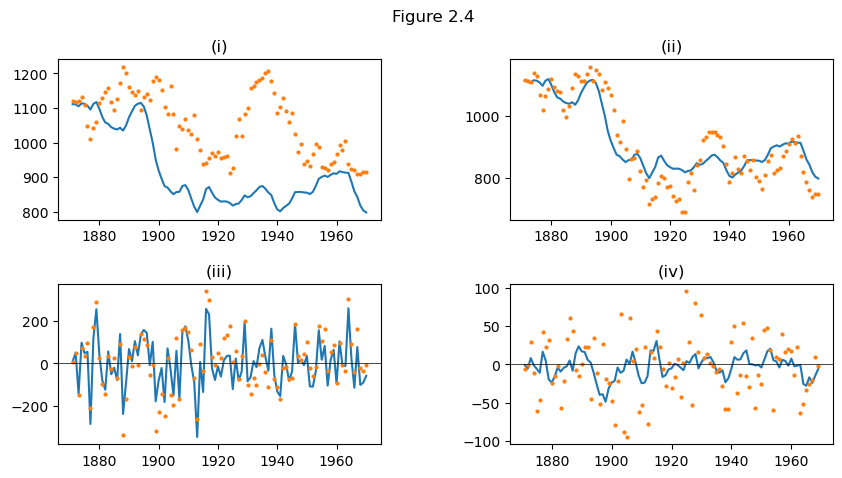

In [78]:
fig_4 = plt.figure(figsize=(10,5))
plt.subplot(2, 2, 1)
plt.plot(df_simulated['Year'], df_simulated['alpha_hat'])
plt.plot(df_simulated['Year'], df_simulated['alpha_plus'], 'o', markersize=2)
plt.title("(i)")

plt.subplot(2, 2, 2)
plt.plot(df_simulated['Year'], df_simulated['alpha_hat'])
plt.plot(df_simulated['Year'], df_simulated['A_tilda'], 'o', markersize=2)
plt.title("(ii)")

plt.subplot(2, 2, 3)
plt.plot(df_simulated['Year'], df_simulated['E_hat'])
plt.plot(df_simulated['Year'], df_simulated['E_tilda'], 'o', markersize=2)
plt.axhline(y=0, color='black', linewidth=0.5)
plt.title("(iii)")

plt.subplot(2, 2, 4)
plt.plot(df_simulated['Year'][:-1], df_simulated['Eta_hat'][:-1])
plt.plot(df_simulated['Year'][:-1], Eta_tilda, 'o', markersize=2)
plt.axhline(y=0, color='black', linewidth=0.5)
plt.title("(iv)")

# add a title for the entire figure
plt.suptitle('Figure 2.4', fontsize= 12)


plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

### Figure 2.5

In [23]:
df3 = df.copy() #creating new df to store data for first figure
df3.rename(columns={'Unnamed: 0': 'Year'}, inplace=True)
df3['at'] = 0
df3['Pt'] = 0
df3['vt'] = 0
df3['Ft'] = 0
df3['Kt'] = 0
df3['rt'] = 0
df3['Nt'] = 0
df3['At'] = 0
df3['Vt'] = 0

df3.head()

,Year,Nile,at,Pt,vt,Ft,Kt,rt,Nt,At,Vt
0,1871,1120,0,0,0,0,0,0,0,0,0
1,1872,1160,0,0,0,0,0,0,0,0,0
2,1873,963,0,0,0,0,0,0,0,0,0
3,1874,1210,0,0,0,0,0,0,0,0,0
4,1875,1160,0,0,0,0,0,0,0,0,0


In [24]:
#### setting missing 
df3.iloc[20:41,1:11] = np.nan
df3.iloc[60:81,1:11] = np.nan
#df3[59:82]

In [25]:
#run kalman filter
#setting initialization
n = len(df3.index)

df3.loc[0,'Pt']= 10**7
df3.head()

,Year,Nile,at,Pt,vt,Ft,Kt,rt,Nt,At,Vt
0,1871,1120.0,0.0,10000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1872,1160.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1873,963.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1874,1210.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1875,1160.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
#creating for loop

for i in range(n):
    if np.isnan(df3.loc[i, 'Nile']):
        #note that when an NA is encountered the next at is set to the current at
        df3.loc[i+1,'at'] = df3.loc[i, 'at']                                     #prediction of level/signal
        df3.loc[i+1,'Pt'] = df3.loc[i, 'Pt'] + sigN
        #prediction variance
    else:
        #note that when we encounter an observation, first vt, Ft and Kt are estimated
        #and then we estimate the next at
        df3.loc[i,'vt'] = df3.loc[i, 'Nile'] - df3.loc[i, 'at']                  #prediction error
        df3.loc[i,'Ft'] = df3.loc[i, 'Pt'] + sigE                                #prediction error variance
        df3.loc[i,'Kt'] = df3.loc[i, 'Pt'] / df3.loc[i, 'Ft']                    #Kalman gain
        df3.loc[i+1,'at'] = df3.loc[i, 'at'] + df3.loc[i, 'Kt']*df3.loc[i, 'vt'] #prediction of level/signal
        df3.loc[i+1,'Pt'] = df3.loc[i, 'Kt']*sigE + sigN                         #prediction variance

df3 = df3.iloc[0:n,:] #removing last row since its not relevant

df3.tail()


,Year,Nile,at,Pt,vt,Ft,Kt,rt,Nt,At,Vt
95,1966.0,746.0,964.188555,5502.472657,-218.188555,20601.472657,0.267091,0.0,0.0,0.0,0.0
96,1967.0,919.0,905.912306,5501.910471,13.087694,20600.910471,0.267071,0.0,0.0,0.0,0.0
97,1968.0,718.0,909.407652,5501.608482,-191.407652,20600.608482,0.267060,0.0,0.0,0.0,0.0
98,1969.0,714.0,858.290232,5501.446255,-144.290232,20600.446255,0.267055,0.0,0.0,0.0,0.0
99,1970.0,740.0,819.756846,5501.359106,-79.756846,20600.359106,0.267052,0.0,0.0,0.0,0.0


In [27]:
for i in range(n-1, -1, -1):
    if np.isnan(df3.loc[i, 'Nile']):
        df3.loc[i-1,'rt'] = df3.loc[i, 'rt']
        df3.loc[i-1,'Nt'] = df3.loc[i, 'Nt']
        df3.loc[i,'At'] = df3.loc[i,'at'] + df3.loc[i,'Pt']*df3.loc[i-1,'rt']
        df3.loc[i,'Vt'] = df3.loc[i,'Pt'] - (df3.loc[i,'Pt']**2)*df3.loc[i-1,'Nt']
            
    else:
        df3.loc[i-1,'rt'] = (df3.loc[i, 'vt'] / df3.loc[i, 'Ft']) + (1-df3.loc[i, 'Kt'])*df3.loc[i, 'rt']
        df3.loc[i-1,'Nt'] = (1 / df3.loc[i, 'Ft']) + ((1-df3.loc[i, 'Kt'])**2)*df3.loc[i, 'Nt']
        df3.loc[i,'At'] = df3.loc[i,'at'] + df3.loc[i,'Pt']*df3.loc[i-1,'rt']
        df3.loc[i,'Vt'] = df3.loc[i,'Pt'] - (df3.loc[i,'Pt']**2)*df3.loc[i-1,'Nt']

df3 = df3.iloc[0:n,:] #removing last row since its not relevant

In [28]:
x_1_1 = df3['Year'][:20]

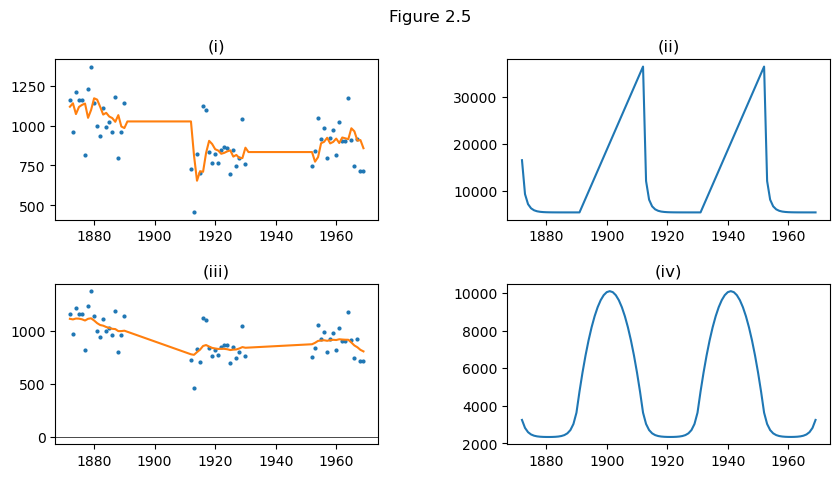

In [71]:
plt_data = df3.copy()
x = plt_data.loc[1:n,'Year'].astype(int)
fig_5 = plt.figure(figsize=(10,5))
plt.subplot(2, 2, 1)
plt.plot(x, plt_data.loc[1:n,'Nile'], 'o', markersize=2)
plt.plot(x, plt_data.loc[1:n,'at'])
plt.title("(i)")

plt.subplot(2, 2, 2)
plt.plot(x, plt_data.loc[1:n,'Pt'])
plt.title("(ii)")

plt.subplot(2, 2, 3)
plt.plot(x, plt_data.loc[1:n,'Nile'] ,'o', markersize=2)
plt.plot(x, plt_data.loc[1:n,'At'])
plt.axhline(y=0, linewidth=0.5, color='black')
plt.title("(iii)")

plt.subplot(2, 2, 4)
plt.plot(x, plt_data.loc[1:n,'Vt'])
plt.title("(iv)")

# add a title for the entire figure
plt.suptitle('Figure 2.5', fontsize= 12)


plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

### Figure 2.6

In [87]:
df4 = df1.drop(['CI_high', 'CI_low'], axis=1).copy()

In [88]:
df4.tail()

,Year,Nile,at,Pt,vt,Ft,Kt
95,1966.0,746.0,963.752506,5501.257942,-217.752506,20600.257942,0.267048
96,1967.0,919.0,905.602132,5501.257942,13.397868,20600.257942,0.267048
97,1968.0,718.0,909.180006,5501.257942,-191.180006,20600.257942,0.267048
98,1969.0,714.0,858.125766,5501.257942,-144.125766,20600.257942,0.267048
99,1970.0,740.0,819.637266,5501.257942,-79.637266,20600.257942,0.267048


In [89]:
# make the j=1 prediction
# Year update
df4.loc[99 + 1,'Year'] = df4.loc[99, 'Year'] + 1
# Pt + 1
df4.loc[99 + 1,'Pt'] = df4.loc[99,'Kt'] * sigE + sigN
# Ft
df4.loc[99 + 1,'Ft'] = df4.loc[99 + 1, 'Pt'] + sigE
# Kt
df4.loc[99 + 1,'Kt'] = df4.loc[99 + 1, 'Pt'] / df4.loc[99 + 1, 'Ft']
# prediction of new at+1
df4.loc[99 + 1, 'at'] = df4.loc[99,'at'] + df4.loc[99,'Kt'] * df4.loc[99,'vt']
# prediction of the observation yt+1, which is equal to at+1 
df4.loc[99 + 1,'Nile'] = df4.loc[99 + 1, 'at']
# new vt
df4.loc[99 + 1,'vt'] = df4.loc[99 + 1, 'Nile'] - df4.loc[99 + 1, 'at']

In [90]:
# 1  year is already predicted, 29 left (from 1 to 29 including)
# make the j > 1 predictions
for j in range(1,30):
    df4.loc[100 + j,'Year'] = df4.loc[100 + (j - 1), 'Year'] + 1
    df4.loc[100 + j,'Ft'] = df4.loc[100 + (j - 1),'Pt'] + sigE
    df4.loc[100 + j,'Kt'] = 0
    df4.loc[100 + j, 'at'] = df4.loc[100 + (j - 1),'at']
    df4.loc[100 + j,'Pt'] = df4.loc[100 + (j - 1),'Pt'] + sigN
    df4.loc[100 + j,'Nile'] = df4.loc[100 + j, 'at'] 
    df4.loc[100 + j,'vt'] = 0

In [91]:
plt_data_Q6 = df4.copy()
n = len(df4)
x = plt_data_Q6.loc[1:n,'Year'].astype(int)
x_1 = plt_data_Q6.loc[1:99,'Year'].astype(int)
x_2 = plt_data_Q6.loc[101:130, 'Year'].astype(int)

In [92]:
# confidence intervals (50%):
conf_up = [(df4.loc[100 + j, 'Nile'] + 0.5 * np.sqrt(df4.loc[100 + j, 'Pt'])) for j in range(1,30)]
conf_down = [(df4.loc[100 + j, 'Nile'] - 0.5 * np.sqrt(df4.loc[100 + j, 'Pt'])) for j in range(1,30)]

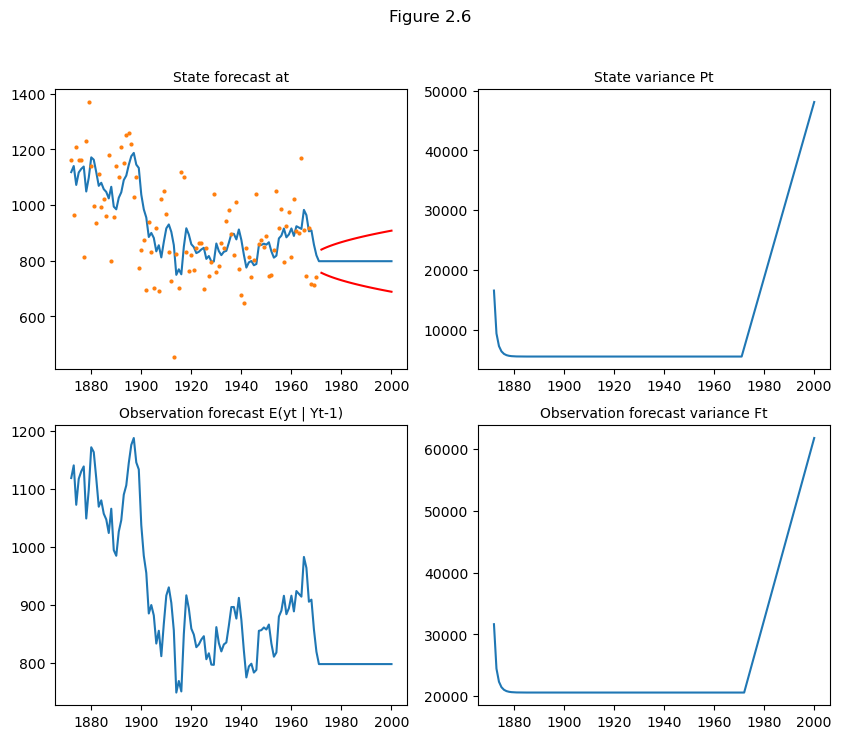

In [94]:
# create a figure with four subplots
fig6, axs = plt.subplots(2, 2, figsize=(10, 8))

# plot the data on each subplot
axs[0, 0].plot(x, plt_data_Q6.loc[1:n,'at'])
axs[0, 0].plot(x_1, plt_data_Q6.loc[1:99,'Nile'], 'o', markersize=2)
axs[0, 0].plot(x_2, conf_up, 'r', markersize=2)
axs[0, 0].plot(x_2, conf_down, 'r', markersize=2)
axs[0, 0].set_title('State forecast at' , fontsize=10)
axs[0, 1].plot(x, plt_data_Q6.loc[1:n,'Pt'])
axs[0, 1].set_title('State variance Pt' , fontsize=10)
axs[1, 0].plot(x, plt_data_Q6.loc[1:n,'at'])
axs[1, 0].set_title('Observation forecast E(yt | Yt-1)', fontsize=10)
axs[1, 1].plot(x, plt_data_Q6.loc[1:n,'Ft'])
axs[1, 1].set_title('Observation forecast variance Ft', fontsize=10)

# add a title for the entire figure
fig6.suptitle('Figure 2.6', fontsize= 12)

# display the plot
plt.show()

### Figure 2.7

In [37]:
df5 = df1.drop(['CI_high', 'CI_low'], axis=1).copy()

In [38]:
# define the one-step-ahead forecast errors
df5['et'] = df5['vt'] / (df5['Ft'].apply(np.sqrt))
df5 = df5.iloc[1:,:]

C:\Users\Asus\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


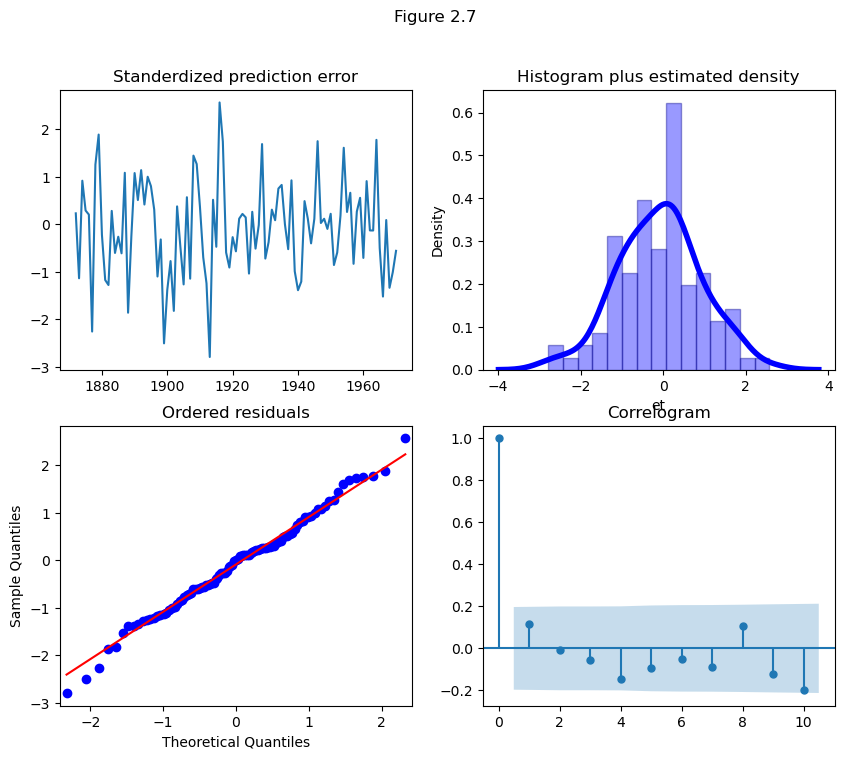

In [85]:
# create a figure with four subplots
fig7, axs = plt.subplots(2, 2, figsize=(10, 8))

# plot the data on each subplot
axs[0, 0].plot(df5['Year'], df5['et'])
axs[0, 0].set_title('Standerdized prediction error')
sns.distplot(df5['et'], hist=True, kde=True, 
             bins=15, color='blue', 
             hist_kws={'edgecolor':'darkblue'},
             kde_kws={'linewidth': 4}, ax=axs[0, 1])
axs[0, 1].set_title('Histogram plus estimated density')
sm.qqplot(df5['et'], line='s', ax=axs[1, 0])
axs[1, 0].set_title('Ordered residuals')
plot_acf(df5['et'], lags=10, ax=axs[1, 1])
axs[1, 1].set_title('Correlogram')

# add a title for the entire figure
fig7.suptitle('Figure 2.7')

# display the plot
plt.show()

### Figure 2.8

In [40]:
df6 = df2_copy.copy()

In [41]:
##creating ut star

df6['ut'] = (df6.loc[:,'vt']/df6.loc[:,'Ft']) - (df6.loc[:,'Kt']*df6.loc[:,'rt'])
df6['Dt'] = (1/df6.loc[:,'Ft'])+ (df6.loc[:,'Kt']**2) * df6.loc[:,'Nt']
df6['ut_star'] = (df6.loc[:,'Dt']** -0.5) * df6.loc[:, 'ut']


In [42]:
df6['rt_star'] = ( df6.loc[:, 'Nt'] ** -0.5) * df6.loc[:, 'rt']

C:\Users\Asus\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Asus\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


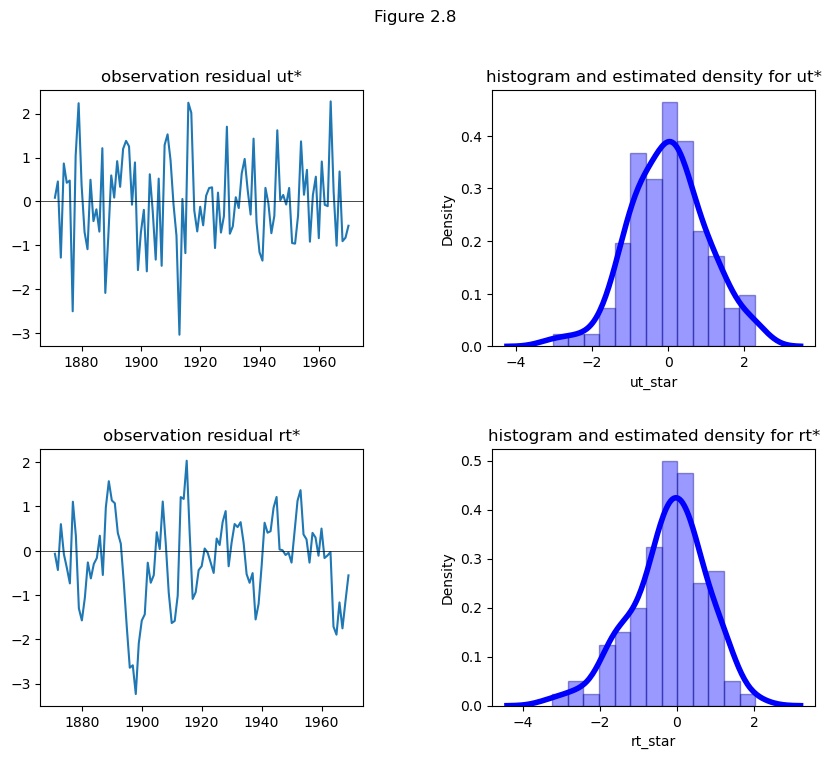

In [86]:
# create a figure with four subplots
fig8, axs = plt.subplots(2, 2, figsize=(10, 8))

# plot the data on each subplot
axs[0, 0].plot(df6['Year'], df6['ut_star'])
axs[0, 0].set_title('observation residual ut*', fontsize=12)
axs[0, 0].axhline(y=0, color='black', linewidth=0.5)

sns.distplot(df6['ut_star'], hist=True, kde=True, 
             bins=13, color='blue', 
             hist_kws={'edgecolor':'darkblue'},
             kde_kws={'linewidth': 4}, ax=axs[0, 1])
axs[0, 1].set_title('histogram and estimated density for ut*', fontsize=12)

axs[1, 0].plot(df6['Year'], df6['rt_star'])
axs[1, 0].set_title('observation residual rt*', fontsize=12)
axs[1, 0].axhline(y=0, color='black', linewidth=0.5)

sns.distplot(df6['rt_star'], hist=True, kde=True, 
             bins=13, color='blue', 
             hist_kws={'edgecolor':'darkblue'},
             kde_kws={'linewidth': 4}, ax=axs[1,1])
axs[1, 1].set_title('histogram and estimated density for rt*' , fontsize=12)


# add a title for the entire figure
fig8.suptitle('Figure 2.8')

# display the plot
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

### Maximum Likelihood

In [44]:
# create a first differenced variable
df['Nile_diff'] = df['Nile'].diff()

# create a lagged first differenced variable
df['Nile_diff_lag'] = df['Nile_diff'].shift(1)

data = df['Nile']

In [45]:
# method of moments
# calculate the covariance between dY and dYlag
sE = -df['Nile_diff'].cov(df['Nile_diff_lag'])
sN = df['Nile_diff'].var() + 2*df['Nile_diff'].cov(df['Nile_diff_lag'])

In [46]:
# Define the log-likelihood function for a local level model
def loglik(params, data):
    sigma_eps = params[0]
    sigma_eta = params[1]
    a0 = 0
    P0 = 10**7 #diffuse initialization
    n = len(data)
    ll = np.zeros(n) #vector to store marginal log likelihoods

    for t in range(n):
        if t == 0:
            at = a0
            Pt = P0
   
        else:
            at = at_prev + Kt_prev*vt_prev
            Pt = Kt_prev*sigma_eps + sigma_eta

        vt = data[t] - at
        Ft = Pt + sigma_eps
        Kt = Pt / Ft
        at_prev, Kt_prev, vt_prev = at, Kt, vt
    
        ll[t] = -0.5 * np.log(2 * np.pi) - 0.5 * (np.log(Ft) + (vt**2 / Ft))
        ll[0] = -0.5 * np.log(2 * np.pi) # setting the first log likelihood so we handle diffuse
        logl = ll.sum() 
        
    return -logl / n #average log likelihood

# Set initial parameter values
params0 = [sE, sN]

# Estimate the parameters using maximum likelihood
result = minimize(loglik, params0, args=(data,), method='Nelder-Mead')

result

 final_simplex: (array([[15100.11704969,  1468.39351444],
       [15100.11711406,  1468.39347455],
       [15100.11713935,  1468.39347568]]), array([6.33463151, 6.33463151, 6.33463151]))
           fun: 6.3346315065874625
       message: 'Optimization terminated successfully.'
          nfev: 129
           nit: 62
        status: 0
       success: True
             x: array([15100.11704969,  1468.39351444])

##### Graph Extraction

In [96]:
# Extracting the plots as pdf:
with PdfPages('Final_Submission.pdf') as pdf:
    pdf.savefig(fig_1)
    pdf.savefig(fig_2)
    pdf.savefig(fig_3)
    pdf.savefig(fig_4)
    pdf.savefig(fig_5)
    pdf.savefig(fig6)
    pdf.savefig(fig7)
    pdf.savefig(fig8)